Wilfredo Gallegos 20399


Paulo Sánchez 21401

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from operator import concat
from sklearn.model_selection import train_test_split


In [87]:
#Data Frame importaciones
dfi=pd.read_csv("ImportacionDS.csv",sep=";")
#Data frame consumo #Archivo consumo
dfc=pd.read_csv("ConsumoDS.csv",sep=";")
#Data Frame precios 
df_p=pd.read_csv("PreciosMensuales.csv",sep=";")
#Seleccionando las columnas por usar
df_imp=dfi[["Fecha","Diesel bajo azufre","Gas licuado de petroleo","Gasolina regular","Gasolina superior"]]
df_con=dfc[["Fecha","Diesel bajo azufre","Gas licuado de petroleo","Gasolina regular","Gasolina superior"]]
df_pre=df_p[["Fecha","Diesel","Gas licuado","Gasolina regular","Gasolina superior"]]


### Preparando la serie de tiempo para trabajar con ella desde del 2018 hasta la actualidad para los tres casos 

In [88]:
meses = {
    'ene': '01', 'feb': '02', 'mar': '03', 'abr': '04', 'may': '05', 'jun': '06',
    'jul': '07', 'ago': '08', 'sep': '09', 'oct': '10', 'nov': '11', 'dic': '12'
}

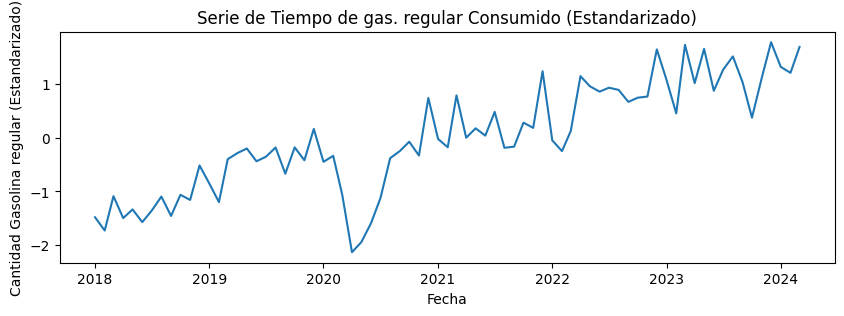

             Tipo     Valor      Fecha
0  Lectura Máxima  1.783135 2023-12-01
1  Lectura Mínima -2.133891 2020-04-01


In [89]:
cons_regular = df_con[['Fecha', 'Gasolina regular']].copy()

# Reemplazar abreviaturas de meses por números
cons_regular['Fecha'] = cons_regular['Fecha'].str.lower().replace(meses, regex=True)

# Convertir a datetime
cons_regular['Fecha'] = pd.to_datetime(cons_regular['Fecha'], format='%m/%Y')

# Limpiar y convertir la columna 'Gasolina regular'
cons_regular['Gasolina regular'] = cons_regular['Gasolina regular'].str.replace(',', '')
cons_regular['Gasolina regular'] = pd.to_numeric(cons_regular['Gasolina regular'], errors='raise')

start_date = '2018-01-01'
end_date = '2024-03-01'
cons_regular = cons_regular.loc[cons_regular['Fecha'] >= start_date]
cons_regular = cons_regular.loc[cons_regular['Fecha'] <= end_date]

# Standardize the 'Gasolina regular' column
scaler = StandardScaler()
cons_regular['Gasolina regular'] = scaler.fit_transform(cons_regular[['Gasolina regular']])

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(cons_regular['Fecha'], cons_regular['Gasolina regular'])
plt.title('Serie de Tiempo de gas. regular Consumido (Estandarizado)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Gasolina regular (Estandarizado)')
# plt.grid(True)
plt.show()

# Encontrar el valor máximo y mínimo
max_value = cons_regular['Gasolina regular'].max()
min_value = cons_regular['Gasolina regular'].min()

# Encontrar las fechas correspondientes al valor máximo y mínimo
max_date = cons_regular[cons_regular['Gasolina regular'] == max_value]['Fecha'].values[0]
min_date = cons_regular[cons_regular['Gasolina regular'] == min_value]['Fecha'].values[0]

# Crear la tabla
summary_table = pd.DataFrame({
    'Tipo': ['Lectura Máxima', 'Lectura Mínima'],
    'Valor': [max_value, min_value],
    'Fecha': [max_date, min_date]
})

# Mostrar la tabla
print(summary_table)

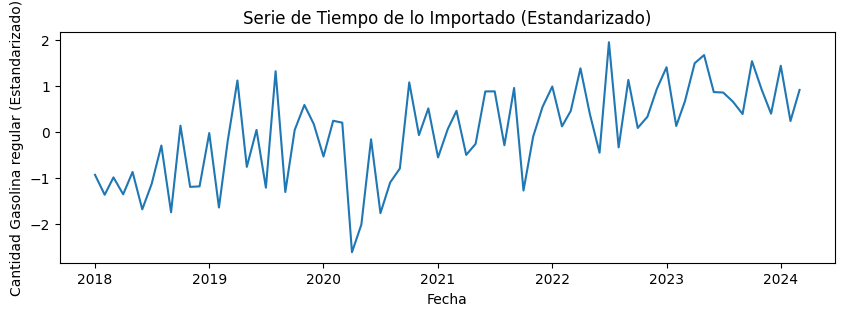

             Tipo     Valor      Fecha
0  Lectura Máxima  1.954351 2022-07-01
1  Lectura Mínima -2.617137 2020-04-01


In [90]:
# Crear una copia del DataFrame para trabajar con él
imp_regular = df_imp[['Fecha', 'Gasolina regular']].copy()

# Reemplazar abreviaturas de meses por números
imp_regular['Fecha'] = imp_regular['Fecha'].str.lower().replace(meses, regex=True)

# Convertir a datetime
imp_regular['Fecha'] = pd.to_datetime(imp_regular['Fecha'], format='%m/%Y')

# Limpiar y convertir la columna 'Gasolina regular'
imp_regular['Gasolina regular'] = imp_regular['Gasolina regular'].str.replace(',', '')
imp_regular['Gasolina regular'] = pd.to_numeric(imp_regular['Gasolina regular'], errors='raise')

start_date = '2018-01-01'
end_date = '2024-03-01'
imp_regular = imp_regular.loc[imp_regular['Fecha'] >= start_date]
imp_regular = imp_regular.loc[imp_regular['Fecha'] <= end_date]

# Standardize the 'Gasolina regular' column
scaler = StandardScaler()
imp_regular['Gasolina regular'] = scaler.fit_transform(imp_regular[['Gasolina regular']])

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(imp_regular['Fecha'], imp_regular['Gasolina regular'])
plt.title('Serie de Tiempo de lo Importado (Estandarizado)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Gasolina regular (Estandarizado)')
# plt.grid(True)
plt.show()

# Encontrar el valor máximo y mínimo
max_value = imp_regular['Gasolina regular'].max()
min_value = imp_regular['Gasolina regular'].min()

# Encontrar las fechas correspondientes al valor máximo y mínimo
max_date = imp_regular[imp_regular['Gasolina regular'] == max_value]['Fecha'].values[0]
min_date = imp_regular[imp_regular['Gasolina regular'] == min_value]['Fecha'].values[0]

# Crear la tabla
summary_table = pd.DataFrame({
    'Tipo': ['Lectura Máxima', 'Lectura Mínima'],
    'Valor': [max_value, min_value],
    'Fecha': [max_date, min_date]
})

# Mostrar la tabla
print(summary_table)

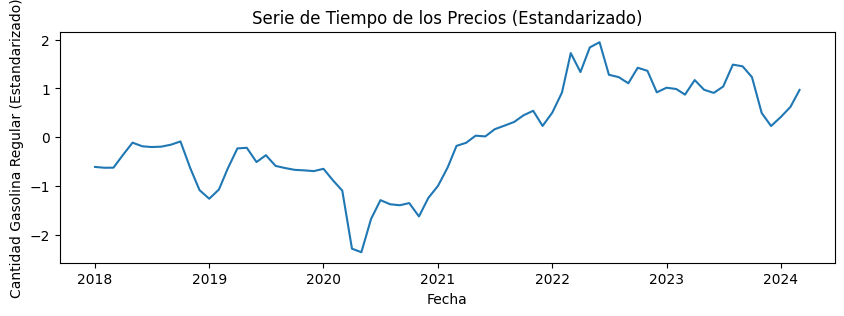

             Tipo     Valor      Fecha
0  Lectura Máxima  1.945971 2022-06-01
1  Lectura Mínima -2.352689 2020-05-01


In [91]:
# Crear una copia del DataFrame para trabajar con él
pre_regular = df_pre[['Fecha', 'Gasolina regular']].copy()

# Reemplazar abreviaturas de meses por números
pre_regular['Fecha'] = pre_regular['Fecha'].str.lower().replace(meses, regex=True)

# Convertir a datetime con el formato 'mm-yy'
pre_regular['Fecha'] = pd.to_datetime(pre_regular['Fecha'], format='%m-%y')

# Filtrar por el rango de fechas
start_date = '2018-01-01'
end_date = '2024-03-01'
pre_regular = pre_regular.loc[pre_regular['Fecha'] >= start_date]
pre_regular = pre_regular.loc[pre_regular['Fecha'] <= end_date]

# Aplicar la transformación logarítmica
pre_regular['Gasolina regular'] = np.log(pre_regular['Gasolina regular'] + 1)

# Standardize the 'Gasolina regular' column
scaler = StandardScaler()
pre_regular['Gasolina regular'] = scaler.fit_transform(pre_regular[['Gasolina regular']])

# Graficar
plt.figure(figsize=(10, 3))
plt.plot(pre_regular["Fecha"], pre_regular["Gasolina regular"])
plt.title('Serie de Tiempo de los Precios (Estandarizado)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Gasolina Regular (Estandarizado)')
# plt.grid(True)
plt.show()

# Encontrar el valor máximo y mínimo
max_value = pre_regular['Gasolina regular'].max()
min_value = pre_regular['Gasolina regular'].min()

# Encontrar las fechas correspondientes al valor máximo y mínimo
max_date = pre_regular[pre_regular['Gasolina regular'] == max_value]['Fecha'].values[0]
min_date = pre_regular[pre_regular['Gasolina regular'] == min_value]['Fecha'].values[0]

# Crear la tabla
summary_table = pd.DataFrame({
    'Tipo': ['Lectura Máxima', 'Lectura Mínima'],
    'Valor': [max_value, min_value],
    'Fecha': [max_date, min_date]
})

# Mostrar la tabla
print(summary_table)

Para mantener estacionalidad se transformo el precio de la Gasolina Regular para que se acoplara y mantuviera la varianza constante para los modelos. 

## Modelo LSTM

### Consumo Gasolina Regular 

#### Primer Modelo

Separando los datos para entrenamiento y para prueba, en este caso se va partir 80% de entrenamiento,20% de validación

In [92]:
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

Se tiene que generar una funcion para preparar los datos para LSTM

In [93]:

# Create sequences
# Definir el número de pasos de tiempo
time_steps = 12  # Puedes ajustar este valor

# Crear secuencias
X, y = create_sequences(cons_regular['Gasolina regular'].values, time_steps)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionar los datos para que sean compatibles con LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

  

Creando el modelo LSTM

In [94]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - loss: 0.5048 - val_loss: 0.8508
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3623 - val_loss: 0.4012
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4240 - val_loss: 0.1766
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3767 - val_loss: 0.2257
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3279 - val_loss: 0.2375
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3089 - val_loss: 0.2150
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4348 - val_loss: 0.2471
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4381 - val_loss: 0.3134
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4199 - val_loss: 0.3932
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3545 - val_loss: 0.3448
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.3995 - val_loss: 0.3407
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3043 - val_loss: 0.3137
Epoch 13/20

Evaluando y prediciendo el modelo

Train Loss: 0.3002121150493622
Test Loss: 0.3006155788898468
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


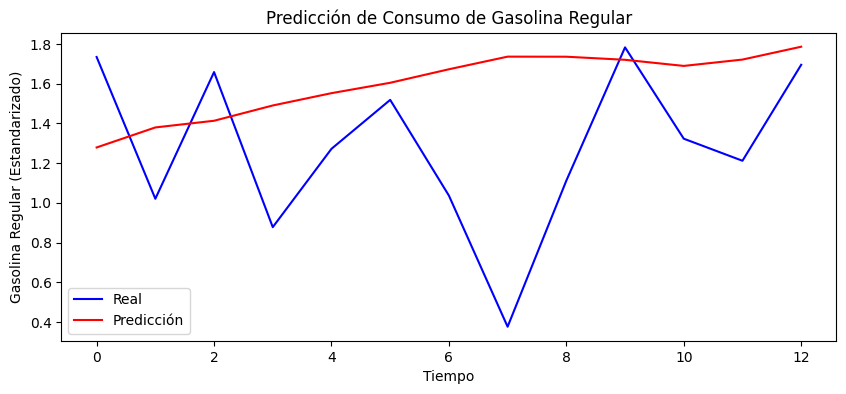

In [95]:
# Evaluar el modelo
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Predecir
predictions = model.predict(X_test)

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicción')
plt.title('Predicción de Consumo de Gasolina Regular')
plt.xlabel('Tiempo')
plt.ylabel('Gasolina Regular (Estandarizado)')
plt.legend()
plt.show()

In [96]:
from keras.optimizers import Adam

### Modelo 1 tuneado para consumo gasolina Regular

Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
MSE: 0.24566560453527042
Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
MSE: 0.20977987860093222
Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
MSE: 0.20483488440059577
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
MSE: 0.35210692129449905
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
MSE: 0.4507483886015138
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
MSE: 0.33763115518294057
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
MSE: 0.4470893621730936
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
MSE: 0.46277045483228235
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
MSE: 0.19817433973642154
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
MSE: 0.28420309408410993
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
MSE: 0.20472370569845794
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
MSE: 0.4034635509569561
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
MSE: 0.367462127560222
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
MSE: 1.1900780269469537
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
MSE: 0.1568054247582483
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
MSE: 0.21676457395753446
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
MSE: 1.2490460478551186
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
MSE: 0.3861625292971448
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
MSE: 0.2638781856793664
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
MSE: 0.1935463837980662
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
MSE: 0.4959856116920104
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
MSE: 0.47560644182929024
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
MSE: 0.24913323253262745
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
MSE: 0.45192223217046656
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
MSE: 0.2716736287334421
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
MSE: 0.4079867912448613
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
MSE: 0.4649253476158348
Mejores parámetros: {'neurons': 100, 'learning_rate': 0.01, 'batch_size': 64} con MSE: 0.1568054247582483
Epoch 1/50


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.6952
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.4950
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.3848
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.3514
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.3332
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.3250
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2994
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2867
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2847
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2818
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2744
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2649
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2572
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2536
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.2518
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/s

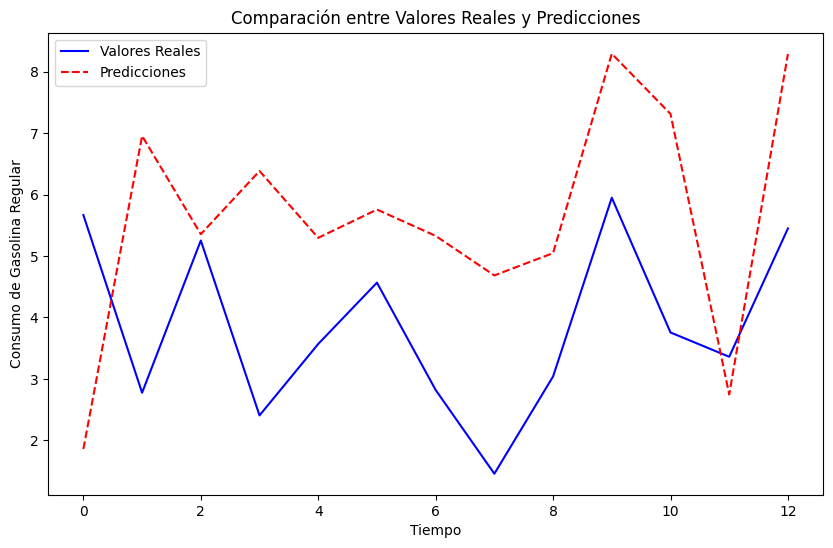

In [97]:
# Hiperparámetros a tunear
neurons = [50, 100, 200]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]

# Mejor configuración
best_mse = float('inf')
best_params = {}

for neuron in neurons:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Evaluando modelo con {neuron} neuronas, learning rate {lr}, batch size {batch_size}")

            # Definir modelo
            model = Sequential()
            model.add(LSTM(neuron, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=lr)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Entrenar modelo
            model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=0, shuffle=False)

            # Predecir y evaluar
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)

            print(f"MSE: {mse}")

            # Guardar mejor configuración
            if mse < best_mse:
                best_mse = mse
                best_params = {'neurons': neuron, 'learning_rate': lr, 'batch_size': batch_size}

print(f"Mejores parámetros: {best_params} con MSE: {best_mse}")
# Definir modelo con los mejores parámetros
model = Sequential()
model.add(LSTM(best_params['neurons'], input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar modelo
optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Entrenar modelo con los mejores parámetros
model.fit(X_train, y_train, epochs=50, batch_size=best_params['batch_size'], verbose=1, shuffle=False)

# Predecir sobre los datos de prueba
predictions = model.predict(X_test)

y_pred_destrans = np.exp(y_pred)   # Ajusta según la transformación que hayas usado
y_test_destrans = np.exp(y_test)  # Ajusta según la transformación que hayas usado

# Crear gráfico
plt.figure(figsize=(10, 6))
plt.plot(y_test_destrans, label='Valores Reales', color='blue')
plt.plot(y_pred_destrans, label='Predicciones', color='red', linestyle='--')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Consumo de Gasolina Regular')
plt.legend()
plt.show()

### Segundo Modelo

Definiendo las secuencias

In [98]:
# Create sequences
# Definir el número de pasos de tiempo
time_steps = 12  # Puedes ajustar este valor

# Crear secuencias
X, y = create_sequences(cons_regular['Gasolina regular'].values, time_steps)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Redimensionar los datos para que sean compatibles con LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Construyendo el modelo

In [99]:
# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.7102 - val_loss: 1.2354
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.6747 - val_loss: 0.7116
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.5553 - val_loss: 0.2696
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4346 - val_loss: 0.2205
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4909 - val_loss: 0.4315
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.3578 - val_loss: 0.3655
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3523 - val_loss: 0.2674
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2771 - val_loss: 0.2632
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.3898 - val_loss: 0.2734
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.3764 - val_loss: 0.3220
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2387 - val_loss: 0.3610
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.3702 - val_loss: 0.4298
E

Evaluacion y graficacion de modelo

Train Loss: 0.2949223518371582
Test Loss: 0.3163798451423645
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


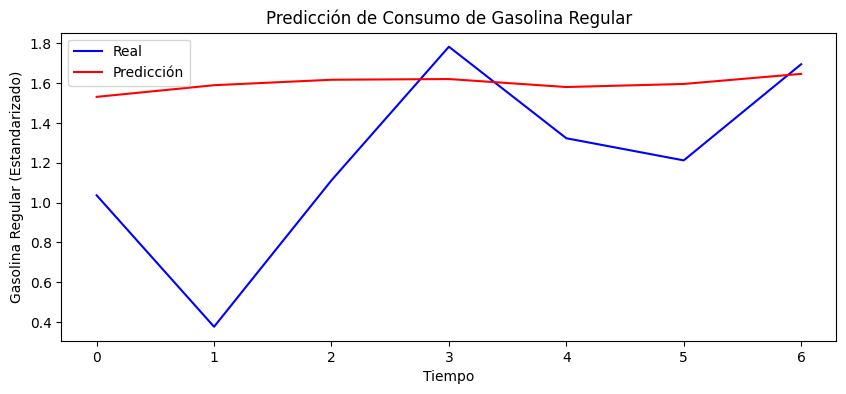

In [100]:
# Evaluar el modelo
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Predecir
predictions = model.predict(X_test)

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicción')
plt.title('Predicción de Consumo de Gasolina Regular')
plt.xlabel('Tiempo')
plt.ylabel('Gasolina Regular (Estandarizado)')
plt.legend()
plt.show()

### Modelo 2 tuneado para consumo gasolina Regular

In [107]:
# Hiperparámetros a tunear
neurons = [50, 100, 200]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]

# Mejor configuración
best_mse = float('inf')
best_params = {}

for neuron in neurons:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Evaluando modelo con {neuron} neuronas, learning rate {lr}, batch size {batch_size}")

            # Definir modelo
            model = Sequential()
            model.add(LSTM(neuron, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=lr)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Entrenar modelo
            model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=0, shuffle=False)

            # Predecir y evaluar
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)

            print(f"MSE: {mse}")

            # Guardar mejor configuración
            if mse < best_mse:
                best_mse = mse
                best_params = {'neurons': neuron, 'learning_rate': lr, 'batch_size': batch_size}

print(f"Mejores parámetros: {best_params} con MSE: {best_mse}")
# Definir modelo con los mejores parámetros
model = Sequential()
model.add(LSTM(best_params['neurons'], input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar modelo
optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Entrenar modelo con los mejores parámetros
model.fit(X_train, y_train, epochs=20, batch_size=best_params['batch_size'], verbose=1, shuffle=False)

# Predecir sobre los datos de prueba
predictions = model.predict(X_test)



Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
MSE: 0.2563250296382962
Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
MSE: 0.2948971279282907
Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
MSE: 0.3058402842320288
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
MSE: 0.21362551049188044
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
MSE: 0.20131159217978317
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
MSE: 0.20028376748726795
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
MSE: 0.19445424160557492
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
MSE: 0.25362552278542017
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
MSE: 0.37921301717251843
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
MSE: 0.22072360054694615
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
MSE: 0.30819022290792414
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
MSE: 0.29151288282019466
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
MSE: 0.21465286266879355
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
MSE: 0.20173769534008668
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
MSE: 0.20690057932802558
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
MSE: 0.2514232191101291
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
MSE: 0.2178366851013882
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
MSE: 0.3472205109970795
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
MSE: 0.2282484482011691
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
MSE: 0.2716945127009136
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
MSE: 0.31420741368554156
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
MSE: 0.21595715540636284
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
MSE: 0.19629733545608202
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
MSE: 0.35391852887390013
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
MSE: 0.19714852727873963
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
MSE: 0.20987622731982988
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
MSE: 1.089615848038269
Mejores parámetros: {'neurons': 50, 'learning_rate': 0.1, 'batch_size': 16} con MSE: 0.19445424160557492
Epoch 1/20


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.2498
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0312  
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9991 
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8014 
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8751 
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1796 
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7845 
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.7992  
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6917 
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6430 
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.4658  
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4244 
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.3419  
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3174 
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2768 
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/st

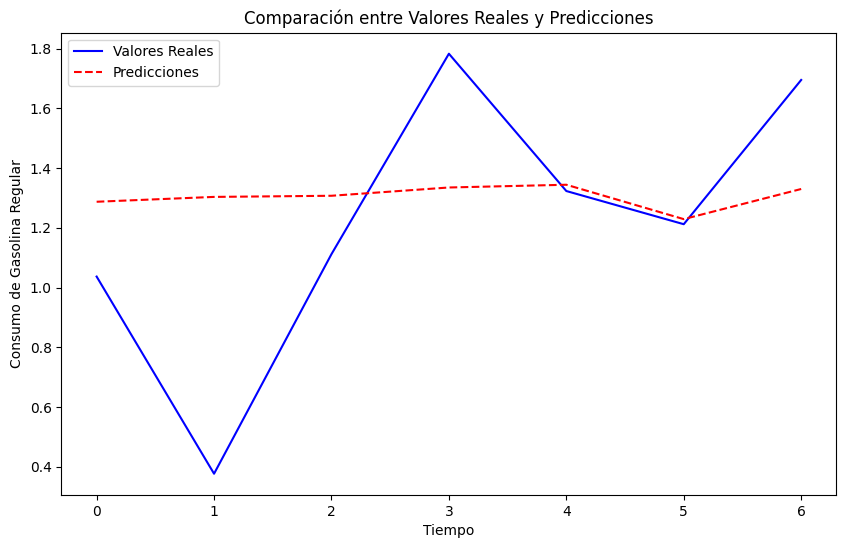

In [109]:
y_pred_destrans = np.exp(y_pred)  # Ajusta según la transformación que hayas usado

# Crear gráfico
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', color='blue')
plt.plot(y_pred_destrans, label='Predicciones', color='red', linestyle='--')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Consumo de Gasolina Regular')
plt.legend()
plt.show()

## Importacion de Gasolina Regular 

### Primer Modelo

Definiendo las secuencias

In [110]:
# Create sequences
# Definir el número de pasos de tiempo
time_steps = 12  # Puedes ajustar este valor

# Crear secuencias
X, y = create_sequences(imp_regular['Gasolina regular'].values, time_steps)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionar los datos para que sean compatibles con LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Construyendo modelo

In [111]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.8092 - val_loss: 0.7568
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.7900 - val_loss: 0.7633
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8817 - val_loss: 0.7322
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8560 - val_loss: 0.6930
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9143 - val_loss: 0.5984
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7745 - val_loss: 0.5159
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8539 - val_loss: 0.4467
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6911 - val_loss: 0.3870
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.7550 - val_loss: 0.3329
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9527 - val_loss: 0.2882
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.8824 - val_loss: 0.2801
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9046 - val_loss: 0.2882


Evaluando y prediciendo el modelo

Train Loss: 0.8119062185287476
Test Loss: 0.3173893392086029
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


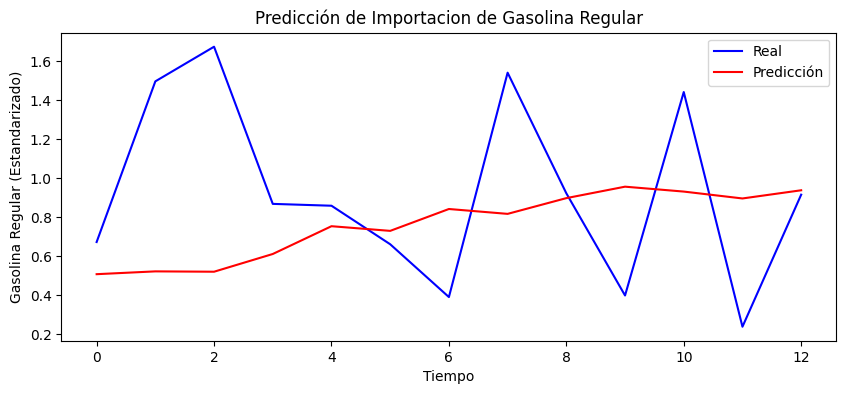

In [112]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Predecir
predictions = model.predict(X_test)

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicción')
plt.title('Predicción de Importacion de Gasolina Regular')
plt.xlabel('Tiempo')
plt.ylabel('Gasolina Regular (Estandarizado)')
plt.legend()
plt.show()

### Modelo 1 tuneado para importación gasolina Regular

In [113]:
# Hiperparámetros a tunear
neurons = [50, 100, 200]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]

# Mejor configuración
best_mse = float('inf')
best_params = {}

for neuron in neurons:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Evaluando modelo con {neuron} neuronas, learning rate {lr}, batch size {batch_size}")

            # Definir modelo
            model = Sequential()
            model.add(LSTM(neuron, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=lr)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Entrenar modelo
            model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=0, shuffle=False)

            # Predecir y evaluar
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)

            print(f"MSE: {mse}")

            # Guardar mejor configuración
            if mse < best_mse:
                best_mse = mse
                best_params = {'neurons': neuron, 'learning_rate': lr, 'batch_size': batch_size}

print(f"Mejores parámetros: {best_params} con MSE: {best_mse}")
# Definir modelo con los mejores parámetros
model = Sequential()
model.add(LSTM(best_params['neurons'], input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar modelo
optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Entrenar modelo con los mejores parámetros
model.fit(X_train, y_train, epochs=20, batch_size=best_params['batch_size'], verbose=1, shuffle=False)

# Predecir sobre los datos de prueba
predictions = model.predict(X_test)



Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
MSE: 0.4641102907668776
Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
MSE: 0.6760641805900046
Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
MSE: 0.7000407656923363
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
MSE: 0.43124716808567787
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
MSE: 1.1759071802202894
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
MSE: 1.8651869340752198
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
MSE: 0.5369055004670802
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
MSE: 0.7937911087517425
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
MSE: 0.46005798636776213
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
MSE: 2.209619594980516
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
MSE: 1.0346732440525404
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
MSE: 1.2091648232843537
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
MSE: 0.4574574019864324
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
MSE: 0.8940044274661949
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
MSE: 0.44161295744822987
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
MSE: 0.5850160010751325
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
MSE: 0.736198467560524
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
MSE: 2.0004559252694287
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
MSE: 2.6598492740165507
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
MSE: 0.29102916441480464
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
MSE: 2.348225442868042
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
MSE: 0.5676711288456777
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
MSE: 0.2790633262900529
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
MSE: 0.3604944908508569
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
MSE: 0.33523489190523686
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
MSE: 0.7728931324009221
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
MSE: 0.5583389796971868
Mejores parámetros: {'neurons': 200, 'learning_rate': 0.01, 'batch_size': 32} con MSE: 0.2790633262900529
Epoch 1/20


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 0s/step - loss: 0.8489
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0585
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.8365  
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.8478  
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8991
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8681
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.8517  
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8378 
Epoch 9/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8307
Epoch 10/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8426
Epoch 11/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8338
Epoch 12/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.8168  
Epoch 13/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8548 
Epoch 14/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8354 
Epoch 15/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 0.8402  
Epoch 16/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

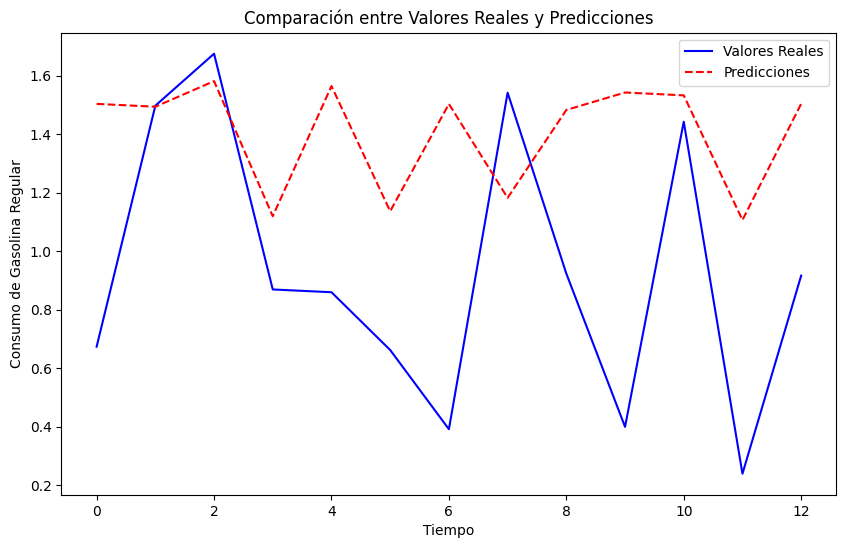

In [116]:
y_pred_destrans = np.exp(y_pred)  # Ajusta según la transformación que hayas usado

# Crear gráfico
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', color='blue')
plt.plot(y_pred_destrans, label='Predicciones', color='red', linestyle='--')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Consumo de Gasolina Regular')
plt.legend()
plt.show()

### Segundo Modelo

In [119]:
# Create sequences
# Definir el número de pasos de tiempo
time_steps = 12  # Puedes ajustar este valor

# Crear secuencias
X, y = create_sequences(imp_regular['Gasolina regular'].values, time_steps)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Redimensionar los datos para que sean compatibles con LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Construyendo modelo

In [120]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.9338 - val_loss: 0.4364
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.8451 - val_loss: 0.2580
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.6540 - val_loss: 0.2627
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.7525 - val_loss: 0.3087
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7939 - val_loss: 0.3186
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.7635 - val_loss: 0.3080
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7290 - val_loss: 0.2902
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7442 - val_loss: 0.2790
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7035 - val_loss: 0.2982
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8969 - val_loss: 0.3706
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.7548 - val_loss: 0.4043
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7702 - val_loss: 0.4679


Train Loss: 0.7378602027893066
Test Loss: 0.49439898133277893
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


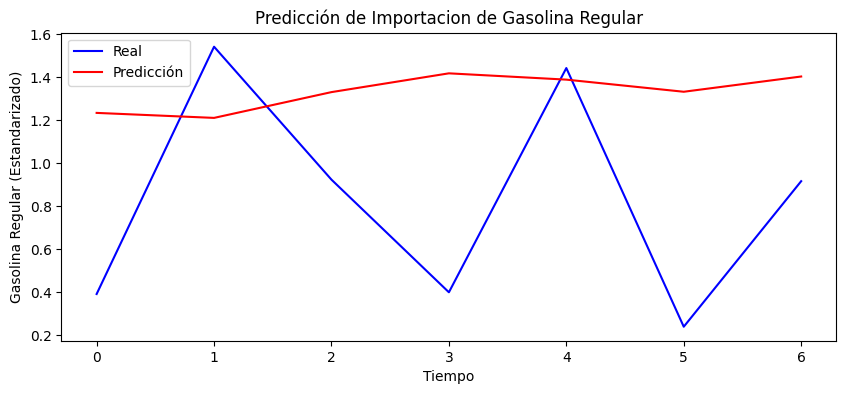

In [121]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Predecir
predictions = model.predict(X_test)

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicción')
plt.title('Predicción de Importacion de Gasolina Regular')
plt.xlabel('Tiempo')
plt.ylabel('Gasolina Regular (Estandarizado)')
plt.legend()
plt.show()

### Modelo 2 tuneado para importación gasolina Regular

In [122]:
# Hiperparámetros a tunear
neurons = [50, 100, 200]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]

# Mejor configuración
best_mse = float('inf')
best_params = {}

for neuron in neurons:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Evaluando modelo con {neuron} neuronas, learning rate {lr}, batch size {batch_size}")

            # Definir modelo
            model = Sequential()
            model.add(LSTM(neuron, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=lr)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Entrenar modelo
            model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=0, shuffle=False)

            # Predecir y evaluar
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)

            print(f"MSE: {mse}")

            # Guardar mejor configuración
            if mse < best_mse:
                best_mse = mse
                best_params = {'neurons': neuron, 'learning_rate': lr, 'batch_size': batch_size}

print(f"Mejores parámetros: {best_params} con MSE: {best_mse}")
# Definir modelo con los mejores parámetros
model = Sequential()
model.add(LSTM(best_params['neurons'], input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar modelo
optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Entrenar modelo con los mejores parámetros
model.fit(X_train, y_train, epochs=20, batch_size=best_params['batch_size'], verbose=1, shuffle=False)

# Predecir sobre los datos de prueba
predictions = model.predict(X_test)



Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
MSE: 0.5407567203812883
Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
MSE: 0.6100360023854539
Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
MSE: 0.5810735731054685
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
MSE: 0.42408108906396924
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
MSE: 0.24252290415252717
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
MSE: 0.20832575762917216
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
MSE: 0.33275563390978985
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
MSE: 0.3830230347796408
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
MSE: 0.2116441726450454
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
MSE: 0.2632022734900238
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
MSE: 0.7264713094641492
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
MSE: 0.6123667382220416
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
MSE: 0.32757063884027576
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
MSE: 0.46324325971543934
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
MSE: 0.1959359522248776
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
MSE: 0.24909401650727928
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
MSE: 0.2063531464302827
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
MSE: 0.7762056187591444
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
MSE: 0.2866463136094418
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
MSE: 0.7162937270658392
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
MSE: 1.2519436814237193
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
MSE: 0.37812282443105716
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
MSE: 0.25530197539003496
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
MSE: 0.34979767945161994
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
MSE: 0.36042213170437915
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
MSE: 0.33458530495717376
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
MSE: 0.44719643520369706
Mejores parámetros: {'neurons': 100, 'learning_rate': 0.01, 'batch_size': 64} con MSE: 0.1959359522248776
Epoch 1/20


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.9295
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.7631
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.8140
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.7644
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.7886
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.7894
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.7791
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.7654
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.7520
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.7438
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.7467
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.7492
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.7371
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.7293
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.7284
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/st

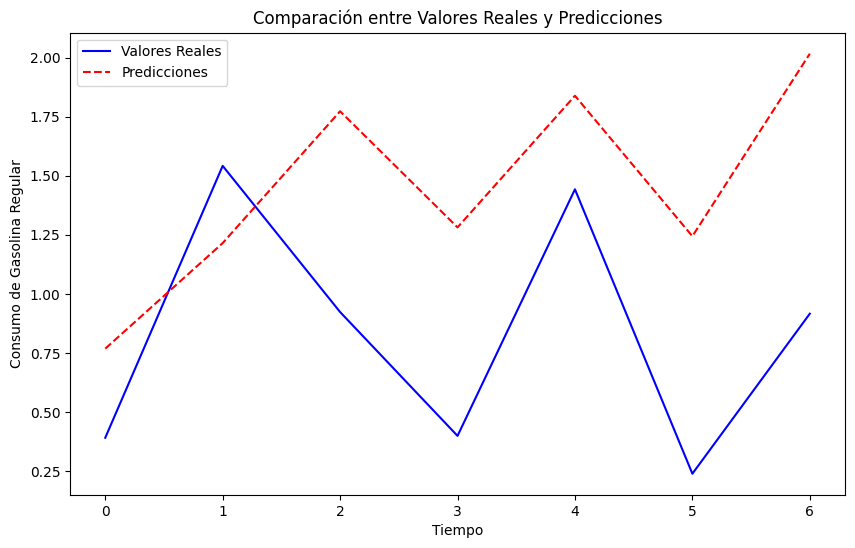

In [123]:
y_pred_destrans = np.exp(y_pred)  # Ajusta según la transformación que hayas usado

# Crear gráfico
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', color='blue')
plt.plot(y_pred_destrans, label='Predicciones', color='red', linestyle='--')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Consumo de Gasolina Regular')
plt.legend()
plt.show()

## Precio Gasolina Regular

### Primer modelo

In [124]:
# Create sequences
# Definir el número de pasos de tiempo
time_steps = 12  # Puedes ajustar este valor

# Crear secuencias
X, y = create_sequences(pre_regular['Gasolina regular'].values, time_steps)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Redimensionar los datos para que sean compatibles con LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [125]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 1.0400 - val_loss: 0.4843
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8886 - val_loss: 0.1868
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.6499 - val_loss: 0.1498
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.5696 - val_loss: 0.3543
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5247 - val_loss: 0.4664
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4188 - val_loss: 0.5025
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4615 - val_loss: 0.4554
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4434 - val_loss: 0.4322
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.3967 - val_loss: 0.3704
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.4519 - val_loss: 0.3165
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.4293 - val_loss: 0.2806
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4148 - val_loss: 0.2731


Train Loss: 0.2390436977148056
Test Loss: 0.29605796933174133
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


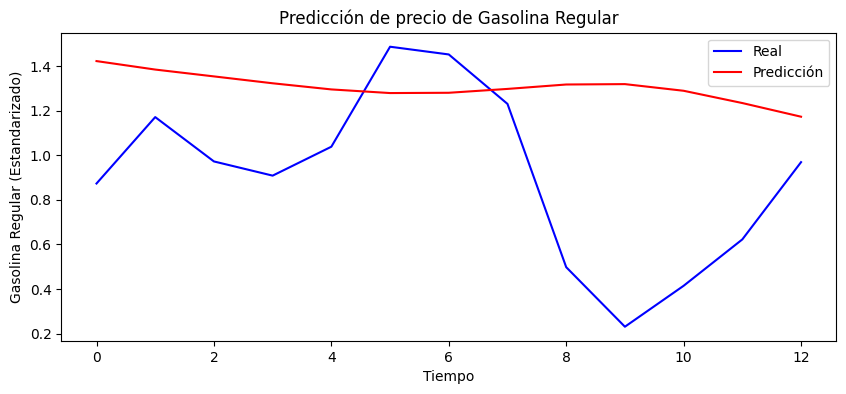

In [126]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Predecir
predictions = model.predict(X_test)

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicción')
plt.title('Predicción de precio de Gasolina Regular')
plt.xlabel('Tiempo')
plt.ylabel('Gasolina Regular (Estandarizado)')
plt.legend()
plt.show()

### Modelo 1 tuneado para precio gasolina Regular

In [128]:
# Hiperparámetros a tunear
neurons = [50, 100, 200]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]

# Mejor configuración
best_mse = float('inf')
best_params = {}

for neuron in neurons:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Evaluando modelo con {neuron} neuronas, learning rate {lr}, batch size {batch_size}")

            # Definir modelo
            model = Sequential()
            model.add(LSTM(neuron, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=lr)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Entrenar modelo
            model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=0, shuffle=False)

            # Predecir y evaluar
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)

            print(f"MSE: {mse}")

            # Guardar mejor configuración
            if mse < best_mse:
                best_mse = mse
                best_params = {'neurons': neuron, 'learning_rate': lr, 'batch_size': batch_size}

print(f"Mejores parámetros: {best_params} con MSE: {best_mse}")
# Definir modelo con los mejores parámetros
model = Sequential()
model.add(LSTM(best_params['neurons'], input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar modelo
optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Entrenar modelo con los mejores parámetros
model.fit(X_train, y_train, epochs=20, batch_size=best_params['batch_size'], verbose=1, shuffle=False)

# Predecir sobre los datos de prueba
predictions = model.predict(X_test)



Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
MSE: 0.1470719647660058
Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
MSE: 0.20940847583942584
Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
MSE: 0.20735792939633044
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
MSE: 0.13998820514460328
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
MSE: 0.19650806465602835
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
MSE: 0.1536021629450386
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
MSE: 0.07888480092000966
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
MSE: 0.2754271442475297
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
MSE: 0.11063489318099871
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
MSE: 0.17191037798997316
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
MSE: 0.16522204718558509
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
MSE: 0.16784341929926136
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
MSE: 0.13838750589998502
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
MSE: 0.21001579831873568
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
MSE: 0.1934028707424287
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
MSE: 0.09540739091934854
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
MSE: 0.25935876813253256
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
MSE: 0.11082847752257265
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
MSE: 0.16474538328550367
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
MSE: 0.15878550496447402
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
MSE: 0.18211108995087005
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
MSE: 0.13427753509559598
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
MSE: 0.2748361238986407
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
MSE: 0.13664589423448018
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
MSE: 1.9653873044859185
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
MSE: 0.5362174699928598
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
MSE: 0.09983094355034579
Mejores parámetros: {'neurons': 50, 'learning_rate': 0.1, 'batch_size': 16} con MSE: 0.07888480092000966
Epoch 1/20


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6235
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6098 
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3539 
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - loss: 1.3096  
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2335 
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1600 
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1189 
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1025 
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0866 
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0869 
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0817 
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0777 
Epoch 13/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0778 
Epoch 14/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0745 
Epoch 15/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0739 
Epoch 16/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/st

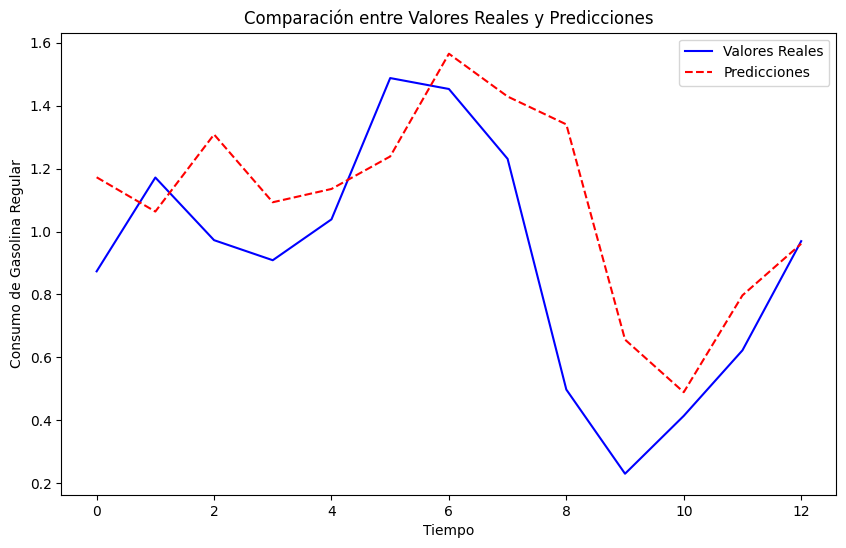

In [131]:
# Crear gráfico
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', color='blue')
plt.plot(y_pred, label='Predicciones', color='red', linestyle='--')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Consumo de Gasolina Regular')
plt.legend()
plt.show()

In [127]:
# Definir modelo con los mejores parámetros
model = Sequential()
model.add(LSTM(best_params['neurons'], input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar modelo
optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Entrenar modelo con los mejores parámetros
model.fit(X_train, y_train, epochs=50, batch_size=best_params['batch_size'], verbose=1, shuffle=False)

# Predecir sobre los datos de prueba
predictions = model.predict(X_test)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.3587
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.6330
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.4090
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.3314
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3197
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.2764
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.2318
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2404
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.2317
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.2160
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.2143
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.2069
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1921
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1806
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1748
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━━━━

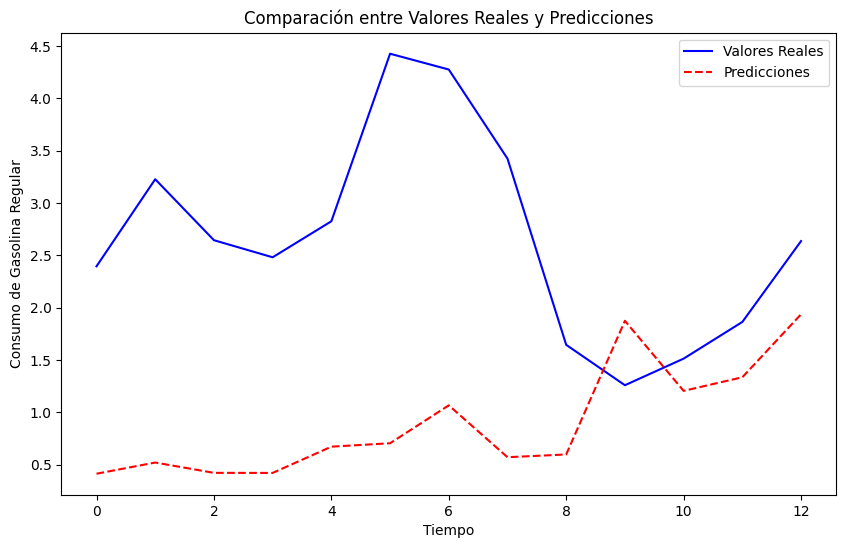

In [84]:
y_pred_destrans = np.exp(y_pred)   # Ajusta según la transformación que hayas usado
y_test_destrans = np.exp(y_test)  # Ajusta según la transformación que hayas usado

# Crear gráfico
plt.figure(figsize=(10, 6))
plt.plot(y_test_destrans, label='Valores Reales', color='blue')
plt.plot(y_pred_destrans, label='Predicciones', color='red', linestyle='--')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Consumo de Gasolina Regular')
plt.legend()
plt.show()

### Segundo Modelo

In [132]:
# Create sequences
# Definir el número de pasos de tiempo
time_steps = 12  # Puedes ajustar este valor

# Crear secuencias
X, y = create_sequences(pre_regular['Gasolina regular'].values, time_steps)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Redimensionar los datos para que sean compatibles con LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [133]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - loss: 1.0306 - val_loss: 0.6695
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.8712 - val_loss: 0.4221
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6895 - val_loss: 0.2490
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6753 - val_loss: 0.1540
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.6063 - val_loss: 0.1197
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6157 - val_loss: 0.1141
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.4959 - val_loss: 0.1276
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.4077 - val_loss: 0.1656
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4514 - val_loss: 0.2759
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.4062 - val_loss: 0.5006
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4315 - val_loss: 0.9545
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3445 - val_loss: 1.4975


Train Loss: 0.20083990693092346
Test Loss: 1.7740825414657593
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step


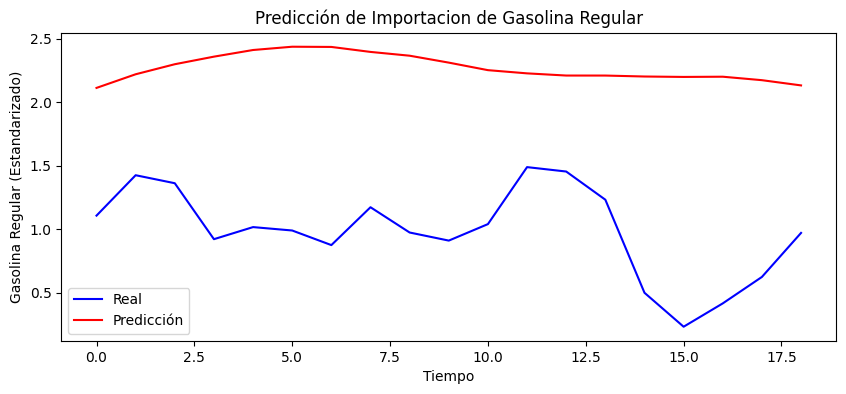

In [134]:
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Train Loss: {train_loss}')
print(f'Test Loss: {test_loss}')

# Predecir
predictions = model.predict(X_test)

# Graficar resultados
plt.figure(figsize=(10, 4))
plt.plot(range(len(y_test)), y_test, color='blue', label='Real')
plt.plot(range(len(predictions)), predictions, color='red', label='Predicción')
plt.title('Predicción de Importacion de Gasolina Regular')
plt.xlabel('Tiempo')
plt.ylabel('Gasolina Regular (Estandarizado)')
plt.legend()
plt.show()

### Modelo 2 tuneado para precio gasolina Regular

In [135]:
# Hiperparámetros a tunear
neurons = [50, 100, 200]
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [16, 32, 64]

# Mejor configuración
best_mse = float('inf')
best_params = {}

for neuron in neurons:
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Evaluando modelo con {neuron} neuronas, learning rate {lr}, batch size {batch_size}")

            # Definir modelo
            model = Sequential()
            model.add(LSTM(neuron, input_shape=(X_train.shape[1], X_train.shape[2])))
            model.add(Dense(1))
            optimizer = Adam(learning_rate=lr)
            model.compile(loss='mean_squared_error', optimizer=optimizer)

            # Entrenar modelo
            model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=0, shuffle=False)

            # Predecir y evaluar
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)

            print(f"MSE: {mse}")

            # Guardar mejor configuración
            if mse < best_mse:
                best_mse = mse
                best_params = {'neurons': neuron, 'learning_rate': lr, 'batch_size': batch_size}

print(f"Mejores parámetros: {best_params} con MSE: {best_mse}")
# Definir modelo con los mejores parámetros
model = Sequential()
model.add(LSTM(best_params['neurons'], input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compilar modelo
optimizer = Adam(learning_rate=best_params['learning_rate'])
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Entrenar modelo con los mejores parámetros
model.fit(X_train, y_train, epochs=20, batch_size=best_params['batch_size'], verbose=1, shuffle=False)

# Predecir sobre los datos de prueba
predictions = model.predict(X_test)



Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 16
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
MSE: 1.148867610673612
Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
MSE: 1.0923678625371267
Evaluando modelo con 50 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
MSE: 0.43622520246479807
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
MSE: 0.2598131088915448
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
MSE: 0.14910431184554043
Evaluando modelo con 50 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
MSE: 0.26097022378768236
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
MSE: 0.39329453669497444
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
MSE: 0.4551048234296214
Evaluando modelo con 50 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
MSE: 0.2427601012690699
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
MSE: 0.7903589955514981
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
MSE: 0.8815345226180519
Evaluando modelo con 100 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
MSE: 2.487281298805385
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
MSE: 0.19647513618400725
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
MSE: 0.23571025311898738
Evaluando modelo con 100 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
MSE: 0.1909602788856526
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
MSE: 0.25216008670169804
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
MSE: 0.9737658801427882
Evaluando modelo con 100 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
MSE: 0.3000886257270193
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
MSE: 0.4333851312673334
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
MSE: 0.5355084527700495
Evaluando modelo con 200 neuronas, learning rate 0.001, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
MSE: 1.511378793568353
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
MSE: 0.1490490563269709
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
MSE: 0.20522048673413162
Evaluando modelo con 200 neuronas, learning rate 0.01, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
MSE: 0.14563266924528043
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 16


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
MSE: 1224.6549057370273
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 32


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
MSE: 47.59686728664964
Evaluando modelo con 200 neuronas, learning rate 0.1, batch size 64


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
MSE: 0.11485027877165063
Mejores parámetros: {'neurons': 200, 'learning_rate': 0.1, 'batch_size': 64} con MSE: 0.11485027877165063
Epoch 1/20


c:\Users\gtgallegoswil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.9930
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 323.8317
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 22.7133
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 4.7811
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 9.2007
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 6.4908
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 9.1599
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.6520
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 3.6161
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 3.9727
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.3875
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.0844
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 2.8639
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.3857
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 1.5863
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66m

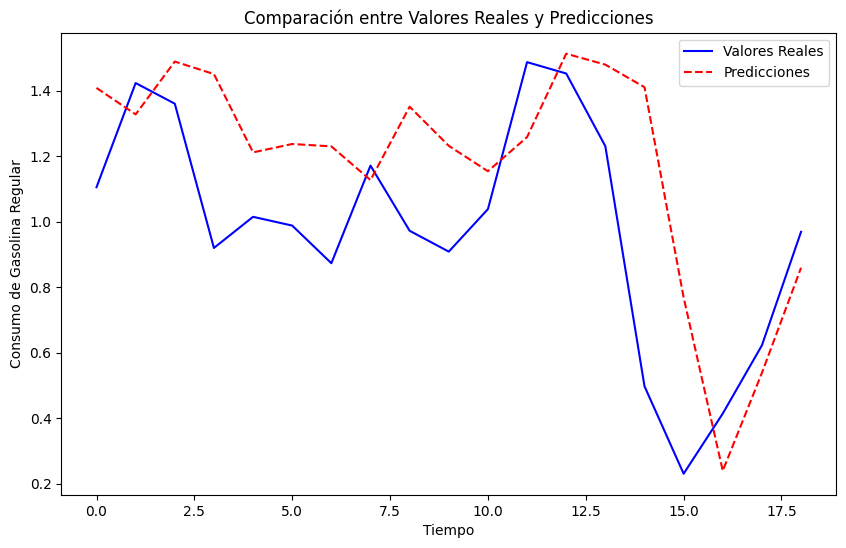

In [137]:
# Crear gráfico
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores Reales', color='blue')
plt.plot(y_pred, label='Predicciones', color='red', linestyle='--')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.xlabel('Tiempo')
plt.ylabel('Consumo de Gasolina Regular')
plt.legend()
plt.show()